<a href="https://colab.research.google.com/github/yyoshiaki/drbonodojo_3-6/blob/master/drbonodojo3_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3.6 データ統合解析

## リファレンスデータセット

### 遺伝子アノテーションデータ

p172〜にならってBiomartからKEGG Pathway and Enzyme IDとGene nameを抽出し、glycolysis(KEGG Pathway ID 00010)の遺伝子を抜き出す。せっかくなのでPythonでやってみよう！

最新版ではGRCh38.p13になっていた。

![image.png](https://github.com/yyoshiaki/drbonodojo_3-6/raw/master/img/biomart.png)

In [0]:
# pandasというデータフレーム処理のライブラリを読み込む。もっともよく使うライブラリ。
import pandas as pd

In [0]:
# mart_export.txtをdfという変数に格納。
df = pd.read_csv('https://raw.githubusercontent.com/yyoshiaki/drbonodojo_3-6/master/mart_export.txt', sep='\t')
df.head()

,KEGG Pathway and Enzyme ID,Gene name
0,NaN,MT-ND1
1,00190+7.1.1.2,MT-ND2
2,00190+1.9.3.1,MT-CO1
3,NaN,MT-CO2
4,NaN,MT-ATP8


In [0]:
# タブで始まる（pandasだと読み込み時にNanになる）行を削除。
df = df.dropna(subset=['KEGG Pathway and Enzyme ID'])
df.head()

,KEGG Pathway and Enzyme ID,Gene name
1,00190+7.1.1.2,MT-ND2
2,00190+1.9.3.1,MT-CO1
9,00190+7.1.1.2,MT-ND4
10,00190+7.1.1.2,MT-ND5
173,00240+2.7.4.6,NME8


In [0]:
# プラス記号をsplitする。
df = pd.concat([df, df['KEGG Pathway and Enzyme ID'].str.split('+', expand=True)[[0,1]]], axis=1)
df.head()

,KEGG Pathway and Enzyme ID,Gene name,0,1
1,00190+7.1.1.2,MT-ND2,00190,7.1.1.2
2,00190+1.9.3.1,MT-CO1,00190,1.9.3.1
9,00190+7.1.1.2,MT-ND4,00190,7.1.1.2
10,00190+7.1.1.2,MT-ND5,00190,7.1.1.2
173,00240+2.7.4.6,NME8,00240,2.7.4.6


In [0]:
# 列を整理する。
df.columns = ['KEGG Pathway and Enzyme ID', 'Gene name', 'KEGG Pathway ID', 'Enzyme ID']
df = df[['KEGG Pathway ID', 'Enzyme ID', 'Gene name']]
df.head()

,KEGG Pathway ID,Enzyme ID,Gene name
1,00190,7.1.1.2,MT-ND2
2,00190,1.9.3.1,MT-CO1
9,00190,7.1.1.2,MT-ND4
10,00190,7.1.1.2,MT-ND5
173,00240,2.7.4.6,NME8


In [0]:
# 00010で始まる行だけ抜き出して第2列でソートし、df_glycolysisという変数に格納。
df_glycolysis = df[df['KEGG Pathway ID'] == '00010'].sort_values(by='Enzyme ID')
df_glycolysis.head()

,KEGG Pathway ID,Enzyme ID,Gene name
24838,00010,1.1.1.1,ADH5
37909,00010,1.1.1.1,ADH7
37896,00010,1.1.1.1,ADH7
37861,00010,1.1.1.1,ADH7
37840,00010,1.1.1.1,ADH7


In [0]:
# 重複を削除して遺伝子名を抽出。
df_glycolysis['Gene name'].unique()

array(['ADH5', 'ADH7', 'ADH4', 'LDHA', 'LDHAL6A', 'LDHC', 'LDHB',
       'LDHAL6B', 'GAPDH', 'GAPDHS', 'PDHA1', 'PDHB', 'PDHA2', 'DLD',
       'DLAT', 'HK3', 'GCK', 'HK1', 'HKDC1', 'HK2', 'PFKM', 'PFKP',
       'PFKL', 'PKM', 'PKLR', 'PGK1', 'PGK2', 'FBP1', 'FBP2', 'G6PC2',
       'G6PC3', 'G6PC', 'PCK2', 'PCK1', 'ALDOB', 'ALDOA', 'ALDOC',
       'AC093512.2', 'ENO2', 'ENO3', 'ENO4', 'ENO1', 'GALM', 'TPI1',
       'GPI', 'AC092073.1', 'BPGM', 'PGAM4', 'PGAM1', 'PGAM2', 'ACSS1',
       'ACSS3', 'AACS', 'ACSS2'], dtype=object)

In [0]:
# 抜き出した遺伝子を表示
for g in df_glycolysis['Gene name'].unique():
  print(g)

ADH5
ADH7
ADH4
LDHA
LDHAL6A
LDHC
LDHB
LDHAL6B
GAPDH
GAPDHS
PDHA1
PDHB
PDHA2
DLD
DLAT
HK3
GCK
HK1
HKDC1
HK2
PFKM
PFKP
PFKL
PKM
PKLR
PGK1
PGK2
FBP1
FBP2
G6PC2
G6PC3
G6PC
PCK2
PCK1
ALDOB
ALDOA
ALDOC
AC093512.2
ENO2
ENO3
ENO4
ENO1
GALM
TPI1
GPI
AC092073.1
BPGM
PGAM4
PGAM1
PGAM2
ACSS1
ACSS3
AACS
ACSS2


In [0]:
# 抜き出した遺伝子を保存。
pd.DataFrame(df_glycolysis['Gene name'].unique()).to_csv('genes_00010.txt', index=None, header=None)

### 遺伝子発現のリファレンスデータセット

RefExからヒトのCAGEデータを取得してみる。

In [0]:
df_cage = pd.read_csv('https://refex.dbcls.jp/download/RefEx_expression_CAGE_all_human_PRJDB1099.tsv.zip',
                      sep='\t', index_col=0)
df_cage.head()

,acantholytic squamous carcinoma cell line:HCC1806,acute lymphoblastic leukemia (B-ALL) cell line:BALL-1,acute lymphoblastic leukemia (B-ALL) cell line:NALM-6,acute lymphoblastic leukemia (T-ALL) cell line:HPB-ALL,acute lymphoblastic leukemia (T-ALL) cell line:Jurkat,acute myeloid leukemia (FAB M0) cell line:Kasumi-3,acute myeloid leukemia (FAB M0) cell line:KG-1,acute myeloid leukemia (FAB M1) cell line:HYT-1,acute myeloid leukemia (FAB M2) cell line:Kasumi-1,acute myeloid leukemia (FAB M2) cell line:Kasumi-6,acute myeloid leukemia (FAB M2) cell line:NKM-1,acute myeloid leukemia (FAB M3) cell line:HL60,acute myeloid leukemia (FAB M4) cell line:FKH-1,acute myeloid leukemia (FAB M4) cell line:HNT-34,acute myeloid leukemia (FAB M4eo) cell line:EoL-1,acute myeloid leukemia (FAB M4eo) cell line:EoL-3,acute myeloid leukemia (FAB M5) cell line:NOMO-1,acute myeloid leukemia (FAB M5) cell line:P31/FUJ,acute myeloid leukemia (FAB M5) cell line:THP-1 (fresh),acute myeloid leukemia (FAB M5) cell line:THP-1 (revived),acute myeloid leukemia (FAB M5) cell line:THP-1 (thawed),acute myeloid leukemia (FAB M5) cell line:U-937 DE-4,acute myeloid leukemia (FAB M6) cell line:EEB,acute myeloid leukemia (FAB M6) cell line:F-36E,acute myeloid leukemia (FAB M6) cell line:F-36P,acute myeloid leukemia (FAB M7) cell line:M-MOK,acute myeloid leukemia (FAB M7) cell line:MKPL-1,adenocarcinoma cell line:IM95m,adrenal cortex adenocarcinoma cell line:SW-13,adult T-cell leukemia cell line:ATN-1,alveolar cell carcinoma cell line:SW 1573,anaplastic carcinoma cell line:8305C,anaplastic large cell lymphoma cell line:Ki-JK,anaplastic squamous cell carcinoma cell line:RPMI 2650,argyrophil small cell carcinoma cell line:TC-YIK,astrocytoma cell line:TM-31,b cell line:RPMI1788,B lymphoblastoid cell line: GM12878 ENCODE,basal cell carcinoma cell line:TE 354.T,bile duct carcinoma cell line:HuCCT1,...,"submaxillary gland, adult","substantia nigra, adult","temporal lobe, adult","testis, adult","thalamus, adult","throat, adult","thymus, adult","thyroid, adult","tongue, adult","tonsil, adult","trachea, adult","uterus, adult","vagina, adult","vein, adult","brain, fetal","colon, fetal","diaphragm, fetal","duodenum, fetal","eye, fetal","heart, fetal","kidney, fetal","liver, fetal","lung, fetal","occipital lobe, fetal","parietal lobe, fetal","rectum, fetal","skeletal muscle, fetal","skin, fetal","small intestine, fetal","spinal cord, fetal","spleen, fetal","stomach, fetal","temporal lobe, fetal","throat, fetal","thymus, fetal","thyroid, fetal","tongue, fetal","trachea, fetal","umbilical cord, fetal","uterus, fetal"
NCBI_GeneID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,0.000000,0.000000,0.253509,0.000000,0.000000,0.000000,0.000000,0.192003,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.183820,0.000000,0.522958,0.479014,0.201860,0.511263,0.000000,2.14206,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.200994,0.000000,3.542956,0.000000,0.478475,0.000000,0.026301,0.483709,0.165291,...,4.587521,5.051373,4.952571,4.885223,4.463458,4.938796,3.467836,5.437813,5.089620,4.354767,6.062548,6.355300,6.336642,5.180200,3.759312,5.169089,5.484675,3.952168,5.221298,6.068228,5.601478,7.631180,7.070896,3.349055,2.758003,5.275575,5.681105,5.341781,4.710917,4.866842,6.097173,4.433888,4.049084,4.901967,4.269933,4.996801,5.502704,5.463231,5.491744,5.434895
9,1.164825,1.938123,2.237258,1.846191,2.061192,2.569925,1.384716,1.965507,2.013894,1.889482,1.585143,1.20902,1.254574,2.072035,2.067532,1.924569,2.055858,1.633558,2.696371,2.973748,2.603703,1.772356,2.14206,0.802393,1.938745,1.673339,1.340182,2.563178,0.114543,2.17487,0.250086,1.136186,2.292475,0.000000,2.869464,1.521569,1.492089,2.158408,2.098498,2.666560,...,0.865497,0.946523,0.185628,1.410244,0.623978,1.845434,1.850167,0.875568,1.342948,1.576722,2.785326,1.369605,1.097702,1.285523,0.000000,1.041368,0.957492,0.853576,0.643916,0.822633,1.147605,0.000000,1.686718,0.000

In [0]:
# 69, 514カラムを抽出する。
df_cage_extracted = df_cage.loc[:,['colon carcinoma cell line:CACO-2', 'small intestine, adult']]
df_cage_extracted.head()

,colon carcinoma cell line:CACO-2,"small intestine, adult"
NCBI_GeneID,,
2,0.000000,5.328502
9,2.264108,2.663829
10,0.448149,3.766171
12,0.991857,2.910402
13,0.353511,5.247834


In [0]:
df_cage_extracted.to_csv('RefEx_1-69-514.txt', sep='\t')

## IDによる連結

### IDの包含関係

KEGG Pathway ID 00020, 000620についても遺伝子リストを取得する。

In [0]:
pd.DataFrame(df.loc[df['KEGG Pathway ID'] == '00020', 'Gene name'].unique()).to_csv(
    'genes_00020.txt', index=None, header=None)

In [0]:
pd.DataFrame(df.loc[df['KEGG Pathway ID'] == '00620', 'Gene name'].unique()).to_csv(
    'genes_00620.txt', index=None, header=None)

#### 自主練習1
出てくる回数をカウントせよ。

http://bioinformatics.psb.ugent.be/webtools/Venn/
に投げると同じ結果が得られる。

![Venn](https://github.com/yyoshiaki/drbonodojo_3-6/raw/master/img/venn_result19700.png)

Pythonの良い点は大概のタスクはライブラリがすでにあること。venn図ももちろんある。

In [0]:
from matplotlib_venn import venn3

In [0]:
genes_00010 = set(df.loc[df['KEGG Pathway ID'] == '00010', 'Gene name'])
genes_00020 = set(df.loc[df['KEGG Pathway ID'] == '00020', 'Gene name'])
genes_00620 = set(df.loc[df['KEGG Pathway ID'] == '00620', 'Gene name'])

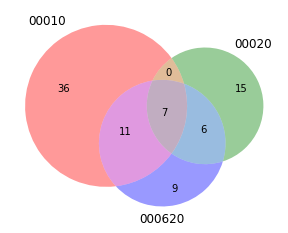

In [0]:
venn3([genes_00010, genes_00020, genes_00620], ['00010', '00020', '000620'])

## データ連結の実際

In [0]:
df_mart_export3 = pd.read_csv('https://raw.githubusercontent.com/bonohu/DrBonoDojo/master/3-6/mart_export3.txt', sep='\t')
df_mart_export3.head()

,Gene name,NCBI gene ID,KEGG Pathway and Enzyme ID
0,MT-ND1,4535.0,NaN
1,MT-ND2,4536.0,00190+1.6.5.3
2,MT-CO1,4512.0,00190+1.9.3.1
3,MT-CO2,4513.0,NaN
4,MT-ATP8,4509.0,NaN


In [0]:
# 欠損値を消しておく。
df_mart_export3 = df_mart_export3.dropna(subset=['NCBI gene ID', 'KEGG Pathway and Enzyme ID'])
df_mart_export3.head()

,Gene name,NCBI gene ID,KEGG Pathway and Enzyme ID
1,MT-ND2,4536.0,00190+1.6.5.3
2,MT-CO1,4512.0,00190+1.9.3.1
9,MT-ND4,4538.0,00190+1.6.5.3
10,MT-ND5,4540.0,00190+1.6.5.3
24,HMOX1,3162.0,00860+1.14.14.18


In [0]:
df_mart_export3.sort_values(by='NCBI gene ID').head()

,Gene name,NCBI gene ID,KEGG Pathway and Enzyme ID
2910,NAT1,9.0,00983+2.3.1.5
2911,NAT1,9.0,00232+2.3.1.5
2912,NAT1,9.0,00633+2.3.1.5
3072,NAT2,10.0,00232+2.3.1.5
3073,NAT2,10.0,00633+2.3.1.5


In [0]:
df_cage_extracted.head()

,colon carcinoma cell line:CACO-2,"small intestine, adult"
NCBI_GeneID,,
2,0.000000,5.328502
9,2.264108,2.663829
10,0.448149,3.766171
12,0.991857,2.910402
13,0.353511,5.247834


In [0]:
# merge用に列（NCBI gene ID）を作る。
df_cage_extracted['NCBI gene ID'] = df_cage_extracted.index
df_cage_extracted.head()

,colon carcinoma cell line:CACO-2,"small intestine, adult",NCBI gene ID
NCBI_GeneID,,,
2,0.000000,5.328502,2
9,2.264108,2.663829,9
10,0.448149,3.766171,10
12,0.991857,2.910402,12
13,0.353511,5.247834,13


In [0]:
df_merged = pd.merge(df_mart_export3, df_cage_extracted, on='NCBI gene ID')
df_merged = df_merged.sort_values(by="NCBI gene ID")
df_merged.head(20)

,Gene name,NCBI gene ID,KEGG Pathway and Enzyme ID,colon carcinoma cell line:CACO-2,"small intestine, adult"
335,NAT1,9.0,00983+2.3.1.5,2.264108,2.663829
336,NAT1,9.0,00232+2.3.1.5,2.264108,2.663829
337,NAT1,9.0,00633+2.3.1.5,2.264108,2.663829
348,NAT2,10.0,00983+2.3.1.5,0.448149,3.766171
349,NAT2,10.0,00232+2.3.1.5,0.448149,3.766171
350,NAT2,10.0,00633+2.3.1.5,0.448149,3.766171
470,AARS,16.0,00970+6.1.1.7,4.413534,3.497334
1374,ABAT,18.0,00410+2.6.1.19,3.437472,3.370442
1376,ABAT,18.0,00640+2.6.1.19,3.437472,3.370442
1377,ABAT,18.0,00650+2.6.1.19,3.437472,3.370442


In [0]:
df_merged[df_merged["KEGG Pathway and Enzyme ID"].str.startswith("00010+")].sort_values(by="colon carcinoma cell line:CACO-2", 
                                                                                        ascending=False).head(10)

,Gene name,NCBI gene ID,KEGG Pathway and Enzyme ID,colon carcinoma cell line:CACO-2,"small intestine, adult"
56,GAPDH,2597.0,00010+1.2.1.12,7.911370,7.217761
1133,LDHB,3945.0,00010+1.1.1.27,7.196754,4.336981
2096,ENO1,2023.0,00010+4.2.1.11,7.083896,6.227354
1438,LDHA,3939.0,00010+1.1.1.27,6.737518,7.251760
2532,PKM,5315.0,00010+2.7.1.40,6.703426,5.677099
28,ALDOA,226.0,00010+4.1.2.13,6.023212,6.221699
2627,PGK1,5230.0,00010+2.7.2.3,5.996850,5.563040
171,GPI,2821.0,00010+5.3.1.9,5.616561,5.692047
479,PFKP,5214.0,00010+2.7.1.11,4.795863,4.210196
1590,PDHA1,5160.0,00010+1.2.4.1,4.497248,4.109022


#### 自主練習2

00010+ または 00020+を抜き出せ。

## 連結するための処理


In [0]:
df_TD = pd.read_csv('https://raw.githubusercontent.com/bonohu/DrBonoDojo/master/3-6/Enolase_C-IACV01.txt', header=None)
df_TD.columns = ['ID']
df_TD

,ID
0,IACV01121558.1.p2
1,IACV01121559.1.p2
2,IACV01093882.1.p2
3,IACV01087655.1.p1
4,IACV01121563.1.p1


In [0]:
df_TD['ID'].str.split('.p').str.get(0)

0    IACV01121558.1
1    IACV01121559.1
2    IACV01093882.1
3    IACV01087655.1
4    IACV01121563.1
Name: ID, dtype: object

fastaは少しめんどくさい構造をしているのでbiopythonやscikit-bioを使うのもおすすめ。

In [0]:
# IACV01.1.fsa_nt.transdecoder.pep.gzをダウンロード。
! wget https://github.com/bonohu/DrBonoDojo/raw/master/3-6/IACV01.1.fsa_nt.transdecoder.pep.gz

--2019-10-15 05:01:54--  https://github.com/bonohu/DrBonoDojo/raw/master/3-6/IACV01.1.fsa_nt.transdecoder.pep.gz
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/bonohu/DrBonoDojo/master/3-6/IACV01.1.fsa_nt.transdecoder.pep.gz [following]
--2019-10-15 05:01:55--  https://raw.githubusercontent.com/bonohu/DrBonoDojo/master/3-6/IACV01.1.fsa_nt.transdecoder.pep.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6121309 (5.8M) [application/octet-stream]
Saving to: ‘IACV01.1.fsa_nt.transdecoder.pep.gz’

IACV01.1.fsa_nt.tra 100%[===================>]   5.84M  --.-KB/s    in 0.09s   

2019-10-15 05:01:55 (62.

In [0]:
! gunzip IACV01.1.fsa_nt.transdecoder.pep.gz

In [0]:
with open('IACV01.1.fsa_nt.transdecoder.pep', 'r') as f:
    line = f.readline() # 1行を文字列として読み込む(改行文字も含まれる)
    l = 0
    while line:
        print(line, end="")
        line = f.readline()
        l += 1
        if l > 20: # 長いので20行で終了する。
          break

>IACV01000035.1.p1 GENE.IACV01000035.1~~IACV01000035.1.p1  ORF type:5prime_partial len:122 (+),score=43.87 IACV01000035.1:1-366(+)
TKTLWVTKVEKFIDYRVTATLEVKNCVPSEFKFPQCQKIHHPPAPHPHPQPHLHPHPPTR
PHKPTSYRPPQHQGNVHYEVPYHDEEPTAEQPAEATHDQKDEKQWVEPNLQPIVDDVFYK
V*
>IACV01000039.1.p1 GENE.IACV01000039.1~~IACV01000039.1.p1  ORF type:internal len:110 (+),score=30.88 IACV01000039.1:1-327(+)
PECLDGALTEALAERFDNEPEDMDVDTIHAEVEKVIVGLSASRWAPEGDLGTAPPPASKP
PPKPSPSAQSAGDTAPQPLGSRFQILADVGETAQDPPPQPTQRKIAPTR
>IACV01000055.1.p1 GENE.IACV01000055.1~~IACV01000055.1.p1  ORF type:internal len:105 (-),score=24.26 IACV01000055.1:2-313(-)
GCAPASALSPEAWPSGLSYKNIGKGNMFPQQHRHCPQPLLLAIRVEHTSLDNGDIVDGAV
IGGGGHESHALDGGEASLDPAKDGVLAVKPWSRSESDEELGAVC
>IACV01000066.1.p1 GENE.IACV01000066.1~~IACV01000066.1.p1  ORF type:3prime_partial len:134 (-),score=1.60 IACV01000066.1:2-400(-)
MFPSDRTSDIIDFPGNTVKVLWNKGKNEYTWDCDSLVQRGKIPQKNIVHIIPGPTPEASN
KLQPYSCFQLFFSDDIMSTILVHTSSEITRQRILYSTNFKANLSDTSIIELKAQLGIQVL
SAALKDNHITTEI
>IACV010000

In [0]:
!perl -pe 's/^\>(\w+)\.p\d+/\>$1/' IACV01.1.fsa_nt.transdecoder.pep | head

>IACV01000035.1.p1 GENE.IACV01000035.1~~IACV01000035.1.p1  ORF type:5prime_partial len:122 (+),score=43.87 IACV01000035.1:1-366(+)
TKTLWVTKVEKFIDYRVTATLEVKNCVPSEFKFPQCQKIHHPPAPHPHPQPHLHPHPPTR
PHKPTSYRPPQHQGNVHYEVPYHDEEPTAEQPAEATHDQKDEKQWVEPNLQPIVDDVFYK
V*
>IACV01000039.1.p1 GENE.IACV01000039.1~~IACV01000039.1.p1  ORF type:internal len:110 (+),score=30.88 IACV01000039.1:1-327(+)
PECLDGALTEALAERFDNEPEDMDVDTIHAEVEKVIVGLSASRWAPEGDLGTAPPPASKP
PPKPSPSAQSAGDTAPQPLGSRFQILADVGETAQDPPPQPTQRKIAPTR
>IACV01000055.1.p1 GENE.IACV01000055.1~~IACV01000055.1.p1  ORF type:internal len:105 (-),score=24.26 IACV01000055.1:2-313(-)
GCAPASALSPEAWPSGLSYKNIGKGNMFPQQHRHCPQPLLLAIRVEHTSLDNGDIVDGAV
IGGGGHESHALDGGEASLDPAKDGVLAVKPWSRSESDEELGAVC


In [0]:
!head IACV01.1.fsa_nt.transdecoder.pep

>IACV01000035.1.p1 GENE.IACV01000035.1~~IACV01000035.1.p1  ORF type:5prime_partial len:122 (+),score=43.87 IACV01000035.1:1-366(+)
TKTLWVTKVEKFIDYRVTATLEVKNCVPSEFKFPQCQKIHHPPAPHPHPQPHLHPHPPTR
PHKPTSYRPPQHQGNVHYEVPYHDEEPTAEQPAEATHDQKDEKQWVEPNLQPIVDDVFYK
V*
>IACV01000039.1.p1 GENE.IACV01000039.1~~IACV01000039.1.p1  ORF type:internal len:110 (+),score=30.88 IACV01000039.1:1-327(+)
PECLDGALTEALAERFDNEPEDMDVDTIHAEVEKVIVGLSASRWAPEGDLGTAPPPASKP
PPKPSPSAQSAGDTAPQPLGSRFQILADVGETAQDPPPQPTQRKIAPTR
>IACV01000055.1.p1 GENE.IACV01000055.1~~IACV01000055.1.p1  ORF type:internal len:105 (-),score=24.26 IACV01000055.1:2-313(-)
GCAPASALSPEAWPSGLSYKNIGKGNMFPQQHRHCPQPLLLAIRVEHTSLDNGDIVDGAV
IGGGGHESHALDGGEASLDPAKDGVLAVKPWSRSESDEELGAVC


## 1対多のデータ処理

重複がないことをその都度確認するのは重要。

In [0]:
df_cage_extracted['NCBI gene ID'].is_unique

True

In [0]:
!pip install sparqldataframe

In [0]:
!pip install simplejson

     |████████████████████████████████| 81kB 3.7MB/s 
  Created wheel for simplejson: filename=simplejson-3.16.0-cp36-cp36m-linux_x86_64.whl size=114022 sha256=7562a6e390e5be7ef3718ed5253e2711fb51b6393d4bcf1b91700517c71efed4
  Stored in directory: /root/.cache/pip/wheels/5d/1a/1e/0350bb3df3e74215cd91325344cc86c2c691f5306eb4d22c77
Successfully built simplejson


In [0]:
!wget https://github.com/bonohu/DrBonoDojo/raw/master/3-6/taxonomy.rq

--2019-10-15 06:36:24--  https://github.com/bonohu/DrBonoDojo/raw/master/3-6/taxonomy.rq
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/bonohu/DrBonoDojo/master/3-6/taxonomy.rq [following]
--2019-10-15 06:36:24--  https://raw.githubusercontent.com/bonohu/DrBonoDojo/master/3-6/taxonomy.rq
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 956 [text/plain]
Saving to: ‘taxonomy.rq’

taxonomy.rq         100%[===================>]     956  --.-KB/s    in 0s      

2019-10-15 06:36:24 (175 MB/s) - ‘taxonomy.rq’ saved [956/956]



In [0]:
!curl -F query=@taxonomy.rq -H "Accept: application/sparql-results+xml" http://togogenome.org/sparql

<html>
<head><title>504 Gateway Time-out</title></head>
<body>
<center><h1>504 Gateway Time-out</h1></center>
<hr><center>nginx/1.16.0</center>
</body>
</html>


In [0]:
import sparqldataframe

sparql_query = """ 
select distinct ?taxonid ?species ?order ?family ?subfamily
where {
  graph <http://togogenome.org/graph/taxonomy> {
    ?sp a <http://ddbj.nig.ac.jp/ontologies/taxonomy/Taxon> .
    ?sp <http://purl.org/dc/terms/identifier> ?taxonid .
    ?sp rdfs:label ?species .
    filter(?taxonid IN(9606, 10090, 7091, 29053))
    ?sp rdfs:subClassOf+ ?parentsf .
    ?parentsf rdfs:label ?subfamily;
      <http://ddbj.nig.ac.jp/ontologies/taxonomy/rank> ?taxranksf .
    ?taxranksf rdfs:label ?ranksf .
    filter(?ranksf = "subfamily")
    ?parentsf rdfs:subClassOf+ ?parentfm .
    ?parentfm rdfs:label ?family;
      <http://ddbj.nig.ac.jp/ontologies/taxonomy/rank> ?taxrankfm .
    ?taxrankfm rdfs:label ?rankfm .
    filter(?rankfm = "family")
    ?parentfm rdfs:subClassOf+ ?parentod .
    ?parentod rdfs:label ?order;
      <http://ddbj.nig.ac.jp/ontologies/taxonomy/rank> ?taxrankod .
    ?taxrankod rdfs:label ?rankod .
    filter(?rankod = "order")
  }
}
"""
df = sparqldataframe.query("http://togogenome.org/sparql", sparql_query)

JSONDecodeError: ignored

In [0]:
df